In [13]:
import logging
import argparse
import json
import os
import nuclei
import model as modellib
import dsbhelper
import random
import visualize
from model import log
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# configure the trainer
config = nuclei.NucleiConfig()

# print the configuration information
config.display()



Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      8
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               500
MEAN_PIXEL                     [0, 0, 0]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI

In [4]:
# download data from gcs if required
local_train_data_path = 'stage1_train'
if not os.path.exists(local_train_data_path):
    dsbhelper.autoload_data(args.zip_folder + '/stage1_train.zip', 'stage1_train.zip', local_train_data_path)

# Instantiate the dataset object and load it with data
dataset_train = nuclei.NucleiDataset()
dataset_train.load_data(local_train_data_path, mode='train', filter_ids=dsbhelper.validation_set)
dataset_train.prepare()


In [5]:
# Validation dataset
dataset_val = nuclei.NucleiDataset()
dataset_val.load_data(local_train_data_path, mode='validate', filter_ids=dsbhelper.validation_set)
dataset_val.prepare()


In [5]:
# Create model in training mode
local_model_folder = './model'
model = modellib.MaskRCNN(mode="training", config=config, model_dir=local_model_folder)


In [6]:
# load pretrained weights for resnet backbone
pretrained = 'imagenet'
if pretrained is 'imagenet':
    gcs_weights_fname = 'gs://mwpdsb/mask_rcnn/pretrained/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    local_weights_fname = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
elif pretrained is 'coco':
    gcs_weights_fname = 'gs://mwpdsb/mask_rcnn/pretrained/mask_rcnn_coco.h5'
    local_weights_fname = 'mask_rcnn_coco.h5'
    
if not os.path.exists(local_weights_fname):
    dsbhelper.copy_file_from_gcs(gcs_weights_fname, local_weights_fname)

if pretrained is 'imagenet':
    model.load_weights(local_weights_fname, by_name=True)
elif pretrained is 'coco':
    model.load_weights(local_weights_fname, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

print('Training with -> {} weights...'.format(pretrained))

Training with -> imagenet weights...


In [7]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')



Starting at epoch 0. LR=0.001

Checkpoint Path: ./model/nuclei20180301T2149/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeD

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/brian_farrar/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
39/39 [==============================] - 407s 10s/step - loss: 3.8377 - rpn_class_loss: 0.6241 - rpn_bbox_loss: 1.9474 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.6265 - mrcnn_mask_loss: 0.5969 - val_loss: 3.6045 - val_rpn_class_loss: 0.3627 - val_rpn_bbox_loss: 2.0578 - val_mrcnn_class_loss: 0.0424 - val_mrcnn_bbox_loss: 0.4959 - val_mrcnn_mask_loss: 0.6456
Epoch 2/10
39/39 [==============================] - 363s 9s/step - loss: 2.9226 - rpn_class_loss: 0.2460 - rpn_bbox_loss: 1.5437 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.4665 - mrcnn_mask_loss: 0.6212 - val_loss: 3.1988 - val_rpn_class_loss: 0.2288 - val_rpn_bbox_loss: 1.9030 - val_mrcnn_class_loss: 0.0575 - val_mrcnn_bbox_loss: 0.4020 - val_mrcnn_mask_loss: 0.6075
Epoch 3/10
39/39 [==============================] - 347s 9s/step - loss: 2.6486 - rpn_class_loss: 0.1674 - rpn_bbox_loss: 1.4500 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.3780 - mrcnn_mask_loss: 0.6003 - val_loss: 2.9494 - val_rpn_class_loss: 

In [6]:
# set up a configuration for inference
class InferenceConfig(nuclei.NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [7]:
# load the model in inference mode
local_model_folder = './model'
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=local_model_folder)


In [8]:
# load trained weights file
local_trained_weights_fname = 'model/nuclei20180301T2149/mask_rcnn_nuclei_0010.h5'
model.load_weights(local_trained_weights_fname, by_name=True)

original_image           shape: (512, 512, 3)         min:    0.00000  max:  138.00000
image_meta               shape: (10,)                 min:    1.00000  max:  384.00000
gt_class_id              shape: (26,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (26, 4)               min:  128.00000  max:  384.00000
gt_mask                  shape: (512, 512, 26)        min:    0.00000  max:    1.00000


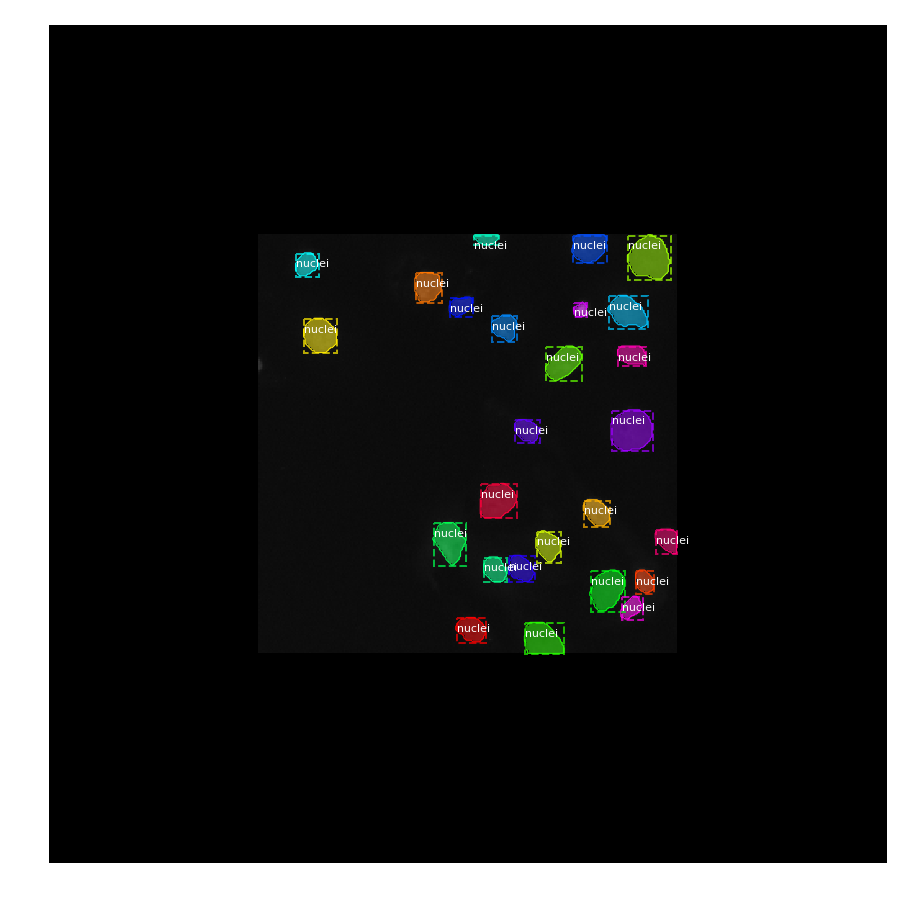

In [9]:
# show the ground truth on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(16, 16))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  138.00000
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  138.00000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


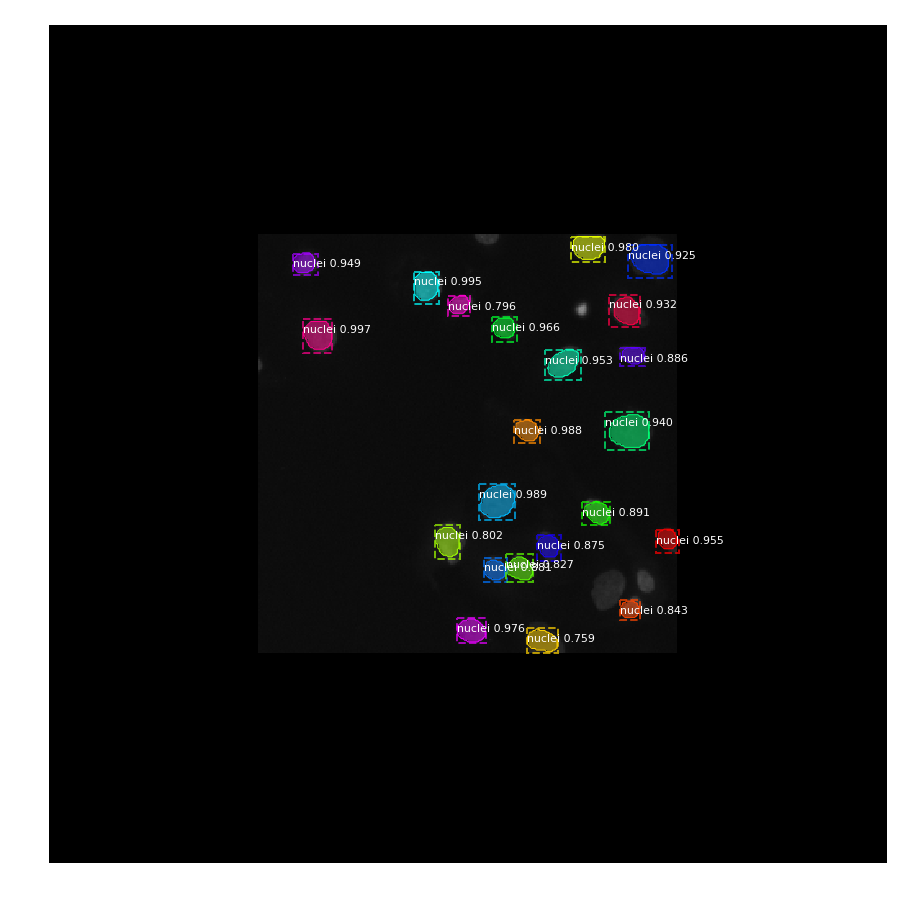

predicted_bbox           shape: (22, 4)               min:  129.00000  max:  385.00000
predicted_mask           shape: (512, 512, 22)        min:    0.00000  max:    1.00000


In [10]:
results = model.detect([original_image], verbose=1)
r = results[0]

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())
log("predicted_bbox", r['rois'])
log("predicted_mask", r['masks'])


In [17]:
# fine tune all layers
model = modellib.MaskRCNN(mode="training", config=config, model_dir=local_model_folder)
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE/10, epochs=10, layers='all')



Starting at epoch 0. LR=0.0001

Checkpoint Path: ./model/nuclei20180302T0211/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Batc

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/brian_farrar/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
39/39 [==============================] - 384s 10s/step - loss: 9.7246 - rpn_class_loss: 1.5968 - rpn_bbox_loss: 5.6281 - mrcnn_class_loss: 0.7441 - mrcnn_bbox_loss: 1.0611 - mrcnn_mask_loss: 0.6946 - val_loss: 7.7995 - val_rpn_class_loss: 1.0214 - val_rpn_bbox_loss: 4.0650 - val_mrcnn_class_loss: 0.7025 - val_mrcnn_bbox_loss: 1.1046 - val_mrcnn_mask_loss: 0.9060
Epoch 2/10
39/39 [==============================] - 361s 9s/step - loss: 5.4033 - rpn_class_loss: 0.6657 - rpn_bbox_loss: 2.4397 - mrcnn_class_loss: 0.7056 - mrcnn_bbox_loss: 0.8402 - mrcnn_mask_loss: 0.7520 - val_loss: 5.4656 - val_rpn_class_loss: 0.7958 - val_rpn_bbox_loss: 2.3587 - val_mrcnn_class_loss: 0.6649 - val_mrcnn_bbox_loss: 0.9036 - val_mrcnn_mask_loss: 0.7426
Epoch 3/10
39/39 [==============================] - 364s 9s/step - loss: 4.5641 - rpn_class_loss: 0.5825 - rpn_bbox_loss: 1.8686 - mrcnn_class_loss: 0.6753 - mrcnn_bbox_loss: 0.7454 - mrcnn_mask_loss: 0.6922 - val_loss: 4.8169 - val_rpn_class_loss: 

In [11]:
# load trained weights file
local_trained_weights_fname = 'model/nuclei20180302T0211/mask_rcnn_nuclei_0010.h5'
model.load_weights(local_trained_weights_fname, by_name=True)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  138.00000
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  138.00000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


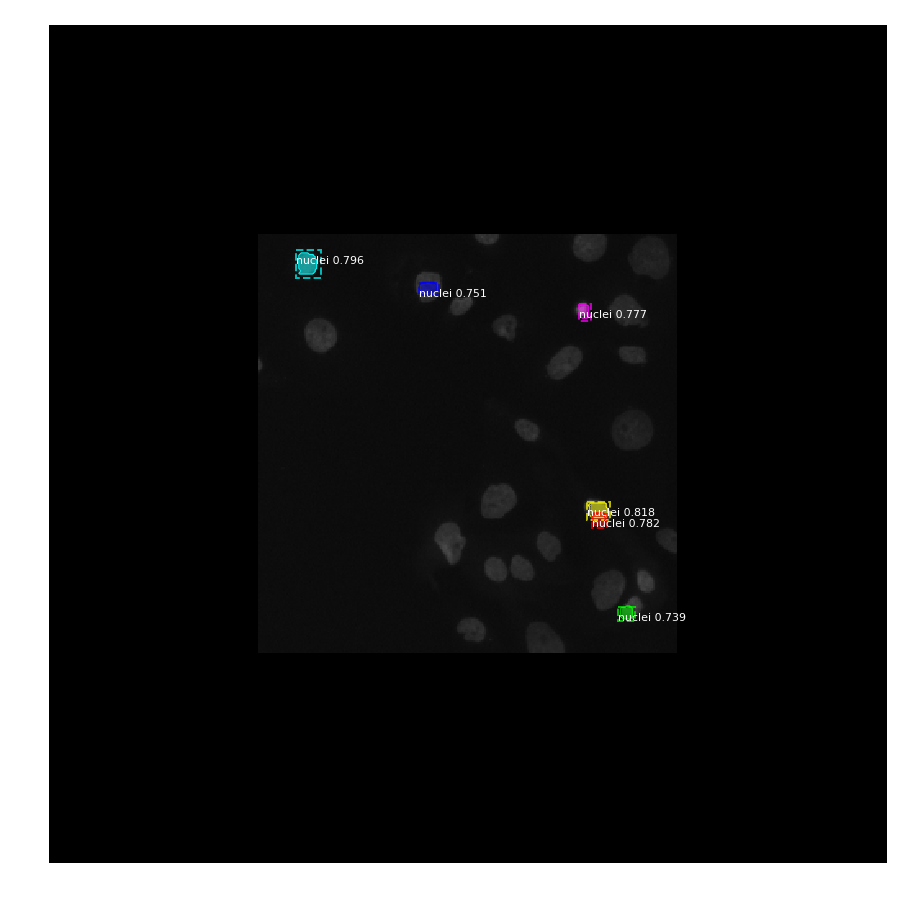

predicted_bbox           shape: (6, 4)                min:  137.00000  max:  364.00000
predicted_mask           shape: (512, 512, 6)         min:    0.00000  max:    1.00000


In [12]:
results = model.detect([original_image], verbose=1)
r = results[0]

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())
log("predicted_bbox", r['rois'])
log("predicted_mask", r['masks'])
